[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を参考に、エージェントを作成する。FXの自動取引を行い、利益を出すのが目標。

In [ ]:
import matplotlib as mpl
mpl.use('tkagg')
import numpy as np
import pandas as pd
import talib
from logging import getLogger, DEBUG, INFO, WARN, ERROR, CRITICAL
import os
import logging
from logging import StreamHandler, LogRecord
import base64

from hist_data import HistData, BitcoinHistData
from fx_trade import FXTrade
from bitcoin_trade import BitcoinTrade
from deep_fx import DeepFX
from debug_tools import DebugTools

Using TensorFlow backend.


In [ ]:
import crcmod
class LogRecordWithCRC16ThereadID(logging.LogRecord):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.crc16threadid = self._calc_crc16(self.process)

    def _calc_crc16(self, int_value):
        byte_array = str(int_value).encode('utf-8')
        crc16 = crcmod.Crc(0x18005)
        crc16.update(byte_array)
        return crc16.hexdigest()

def init_logger(sd_loglevel=logging.WARN, stream_loglevel=logging.CRITICAL):
    logging.setLogRecordFactory(LogRecordWithCRC16ThereadID)
    logger = logging.getLogger('deepfx')
    logger.setLevel(sd_loglevel)
    formatter = logging.Formatter('[%(crc16threadid)s] %(message)s')

    if sd_loglevel:
        import google
        from google.cloud.logging import Client
        from google.cloud.logging.handlers import CloudLoggingHandler
        client = google.cloud.logging.Client \
            .from_service_account_json(os.environ.get('GOOGLE_SERVICE_ACCOUNT_JSON_PATH'))
        handler = CloudLoggingHandler(client, name='deepfx')
        handler.setLevel(sd_loglevel)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = None

    if stream_loglevel:
        handler = StreamHandler()
        handler.setLevel(stream_loglevel)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = None

    return logger

In [ ]:
deepfx_logger = init_logger(stream_loglevel=None)
deepfx_logger.critical('DeepFX Started: %s' % DebugTools.now_str())
deepfx_logger.debug   ('loglevel debug    test')
deepfx_logger.info    ('loglevel info     test')
deepfx_logger.warning ('loglevel warn     test')
deepfx_logger.error   ('loglevel error    test')
deepfx_logger.critical('loglevel critical test')

In [ ]:
is_for_fx = False
is_for_bitcoin = True

In [ ]:
if is_for_fx:
    hd = HistData(csv_path = 'historical_data/DAT_ASCII_USDJPY_M1_201710_h1.csv',
                     begin_date='2017-10-02T00:00:00',
                     end_date='2017-10-02T01:59:59')
elif is_for_bitcoin:
    hd = HistData(csv_path = 'historical_data/coincheckJPY_1-min_data_2014-10-31_to_2017-10-20_h1.csv',
                     begin_date='2017-10-02T00:00:00',
                     end_date='2017-10-02T01:59:59')

header is included


In [ ]:
hd.data()
len(hd.data())

2

In [ ]:
if is_for_fx:
    env = FXTrade(1000000, 0.08, hd, logger=deepfx_logger)
    #env = FXTrade(1000000, 0.08, h, logger=logger)
    prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq1.440944e+06_episode00003.h5'
    dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 100000, logger=deepfx_logger)
elif is_for_bitcoin:
    env = BitcoinTrade(10000000, None, hd, logger=deepfx_logger)
    #env = FXTrade(1000000, 0.08, h, logger=logger)
    prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq1.440944e+06_episode00003.h5'
    dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 1000, logger=deepfx_logger)
    #dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 1000, logger=deepfx_logger)

In [ ]:
is_to_train = True
if is_to_train:
    dfx.train(is_for_time_measurement=True)
else:
    dfx.test(1, [EpisodeLogger()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Training for 1000 steps ...
Training for 1000 steps ...
   1/1000: episode: 1, duration: 0.850s, episode steps: 1, steps per second: 1, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
   1/1000: episode: 1, duration: 0.854s, episode steps: 1, steps per second: 1, episode rewa

  20/1000: episode: 20, duration: 0.010s, episode steps: 1, steps per second: 99, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  21/1000: episode: 21, duration: 0.009s, episode steps: 1, steps per second: 108, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  21/1000: episode: 21, duration: 0.012s, episode steps: 1, steps per second: 83, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  22/1000: episode: 22, duration: 0.007s, episode steps: 1, steps per second: 133, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mea

  37/1000: episode: 37, duration: 0.009s, episode steps: 1, steps per second: 110, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  38/1000: episode: 38, duration: 0.017s, episode steps: 1, steps per second: 60, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  38/1000: episode: 38, duration: 0.023s, episode steps: 1, steps per second: 43, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  39/1000: episode: 39, duration: 0.011s, episode steps: 1, steps per second: 90, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean

  55/1000: episode: 55, duration: 0.008s, episode steps: 1, steps per second: 129, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  55/1000: episode: 55, duration: 0.010s, episode steps: 1, steps per second: 99, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  56/1000: episode: 56, duration: 0.010s, episode steps: 1, steps per second: 99, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  56/1000: episode: 56, duration: 0.012s, episode steps: 1, steps per second: 82, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean

  74/1000: episode: 74, duration: 0.009s, episode steps: 1, steps per second: 106, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  74/1000: episode: 74, duration: 0.012s, episode steps: 1, steps per second: 86, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  75/1000: episode: 75, duration: 0.007s, episode steps: 1, steps per second: 140, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  75/1000: episode: 75, duration: 0.009s, episode steps: 1, steps per second: 112, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], me

  94/1000: episode: 94, duration: 0.011s, episode steps: 1, steps per second: 95, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  94/1000: episode: 94, duration: 0.012s, episode steps: 1, steps per second: 84, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  95/1000: episode: 95, duration: 0.008s, episode steps: 1, steps per second: 125, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: --, mean_q: --
  95/1000: episode: 95, duration: 0.010s, episode steps: 1, steps per second: 105, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mea

 109/1000: episode: 109, duration: 0.244s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817592433224227749888.000000, mean_q: 202099.562500
 109/1000: episode: 109, duration: 0.245s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817592433224227749888.000000, mean_q: 202099.562500
 110/1000: episode: 110, duration: 0.244s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47987141115904.000000, mean_q: 203352.515625
 110/1000: episode: 110, duration: 0.246s, episode steps: 1, steps per second: 4, episode reward: 1000

 124/1000: episode: 124, duration: 0.257s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 48338049171456.000000, mean_q: 220847.968750
 124/1000: episode: 124, duration: 0.258s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 48338049171456.000000, mean_q: 220847.968750
 125/1000: episode: 125, duration: 0.242s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 48065528463360.000000, mean_q: 222019.390625
 125/1000: episode: 125, duration: 0.243s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean r

 138/1000: episode: 138, duration: 0.274s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817591870274274328576.000000, mean_q: 238358.656250
 138/1000: episode: 138, duration: 0.276s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817591870274274328576.000000, mean_q: 238358.656250
 139/1000: episode: 139, duration: 0.239s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908795794399648808960.000000, mean_q: 239829.093750
 139/1000: episode: 139, duration: 0.247s, episode steps: 1, steps per second: 4, episode rewar

 153/1000: episode: 153, duration: 0.252s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908795583293416275968.000000, mean_q: 259045.359375
 153/1000: episode: 153, duration: 0.255s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908795583293416275968.000000, mean_q: 259045.359375
 154/1000: episode: 154, duration: 0.283s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47694273839104.000000, mean_q: 260311.781250
 154/1000: episode: 154, duration: 0.287s, episode steps: 1, steps per second: 3, episode reward: 100000

 168/1000: episode: 168, duration: 0.222s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47527772553216.000000, mean_q: 277687.031250
 168/1000: episode: 168, duration: 0.223s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47527772553216.000000, mean_q: 277687.031250
 169/1000: episode: 169, duration: 0.198s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47515181252608.000000, mean_q: 279000.468750
 169/1000: episode: 169, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean r

 183/1000: episode: 183, duration: 0.213s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817590603636879130624.000000, mean_q: 296639.218750
 183/1000: episode: 183, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817590603636879130624.000000, mean_q: 296639.218750
 184/1000: episode: 184, duration: 0.247s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47469077463040.000000, mean_q: 298009.750000
 184/1000: episode: 184, duration: 0.249s, episode steps: 1, steps per second: 4, episode reward: 1000

 197/1000: episode: 197, duration: 0.275s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817590181424414064640.000000, mean_q: 315811.375000
 197/1000: episode: 197, duration: 0.279s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817590181424414064640.000000, mean_q: 315811.375000
 198/1000: episode: 198, duration: 0.265s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 47013416665088.000000, mean_q: 317275.968750
 198/1000: episode: 198, duration: 0.271s, episode steps: 1, steps per second: 4, episode reward: 1000

 212/1000: episode: 212, duration: 0.258s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46663271972864.000000, mean_q: 339434.281250
 212/1000: episode: 212, duration: 0.262s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46663271972864.000000, mean_q: 339434.281250
 213/1000: episode: 213, duration: 0.199s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817589618474460643328.000000, mean_q: 340867.218750
 213/1000: episode: 213, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 10000000.000

 226/1000: episode: 226, duration: 0.259s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46620452323328.000000, mean_q: 358208.781250
 226/1000: episode: 226, duration: 0.260s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46620452323328.000000, mean_q: 358208.781250
 227/1000: episode: 227, duration: 0.262s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46608771186688.000000, mean_q: 359433.281250
 227/1000: episode: 227, duration: 0.266s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean r

 241/1000: episode: 241, duration: 0.257s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46437106712576.000000, mean_q: 377423.187500
 241/1000: episode: 241, duration: 0.258s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46437106712576.000000, mean_q: 377423.187500
 242/1000: episode: 242, duration: 0.265s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908794457393509433344.000000, mean_q: 378827.031250
 242/1000: episode: 242, duration: 0.267s, episode steps: 1, steps per second: 4, episode reward: 10000000.000,

 255/1000: episode: 255, duration: 0.263s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46239148146688.000000, mean_q: 398177.281250
 255/1000: episode: 255, duration: 0.267s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 46239148146688.000000, mean_q: 398177.281250
 256/1000: episode: 256, duration: 0.247s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817588633312042156032.000000, mean_q: 399678.937500
 256/1000: episode: 256, duration: 0.252s, episode steps: 1, steps per second: 4, episode reward: 10000000.000

 269/1000: episode: 269, duration: 0.208s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 908794105549788545024.000000, mean_q: 420210.187500
 269/1000: episode: 269, duration: 0.211s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 908794105549788545024.000000, mean_q: 420210.187500
 270/1000: episode: 270, duration: 0.278s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908794105549788545024.000000, mean_q: 421765.531250
 270/1000: episode: 270, duration: 0.281s, episode steps: 1, steps per second: 4, episode reward:

 284/1000: episode: 284, duration: 0.188s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 45653237432320.000000, mean_q: 444557.718750
 284/1000: episode: 284, duration: 0.189s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 45653237432320.000000, mean_q: 444557.718750
 285/1000: episode: 285, duration: 0.196s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 45926160793600.000000, mean_q: 446125.781250
 285/1000: episode: 285, duration: 0.198s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean r

 298/1000: episode: 298, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817587225937158602752.000000, mean_q: 468424.281250
 298/1000: episode: 298, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817587225937158602752.000000, mean_q: 468424.281250
 299/1000: episode: 299, duration: 0.189s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 45553517854720.000000, mean_q: 470248.968750
 299/1000: episode: 299, duration: 0.192s, episode steps: 1, steps per second: 5, episode reward: 1000

 313/1000: episode: 313, duration: 0.196s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 45187925540864.000000, mean_q: 493377.531250
 313/1000: episode: 313, duration: 0.197s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 45187925540864.000000, mean_q: 493377.531250
 314/1000: episode: 314, duration: 0.190s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 45613966163968.000000, mean_q: 494807.250000
 314/1000: episode: 314, duration: 0.193s, episode steps: 1, steps per second: 5, epis

 327/1000: episode: 327, duration: 0.336s, episode steps: 1, steps per second: 3, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908793120387370057728.000000, mean_q: 517417.812500
 327/1000: episode: 327, duration: 0.340s, episode steps: 1, steps per second: 3, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908793120387370057728.000000, mean_q: 517417.812500
 328/1000: episode: 328, duration: 0.209s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908793120387370057728.000000, mean_q: 519262.781250
 328/1000: episode: 328, duration: 0.210s, episode steps: 1, steps per second: 5, episode reward:

 341/1000: episode: 341, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817585677824786694144.000000, mean_q: 543167.062500
 341/1000: episode: 341, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817585677824786694144.000000, mean_q: 543167.062500
 342/1000: episode: 342, duration: 0.391s, episode steps: 1, steps per second: 3, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817585396349809983488.000000, mean_q: 545211.562500
 342/1000: episode: 342, duration: 0.393s, episode steps: 1, steps per second: 3, episode rewa

 355/1000: episode: 355, duration: 0.271s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 44469458042880.000000, mean_q: 569256.562500
 355/1000: episode: 355, duration: 0.275s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 44469458042880.000000, mean_q: 569256.562500
 356/1000: episode: 356, duration: 0.223s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 44604250390528.000000, mean_q: 570899.937500
 356/1000: episode: 356, duration: 0.227s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean r

 369/1000: episode: 369, duration: 0.288s, episode steps: 1, steps per second: 3, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 44252528640000.000000, mean_q: 592286.937500
 369/1000: episode: 369, duration: 0.297s, episode steps: 1, steps per second: 3, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 44252528640000.000000, mean_q: 592286.937500
 370/1000: episode: 370, duration: 0.283s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 1817584692662368206848.000000, mean_q: 594048.250000
 370/1000: episode: 370, duration: 0.289s, episode steps: 1, steps per second: 3, episode reward: 10000000.000

 383/1000: episode: 383, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 908792135224951570432.000000, mean_q: 619356.937500
 383/1000: episode: 383, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 908792135224951570432.000000, mean_q: 619356.937500
 384/1000: episode: 384, duration: 0.212s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 908792135224951570432.000000, mean_q: 621307.562500
 384/1000: episode: 384, duration: 0.213s, episode steps: 1, step

 397/1000: episode: 397, duration: 0.197s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 2726375068668715335680.000000, mean_q: 663991.812500
 397/1000: episode: 397, duration: 0.199s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 2726375068668715335680.000000, mean_q: 663991.812500
 398/1000: episode: 398, duration: 0.200s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 1817583426024973008896.000000, mean_q: 669122.500000
 398/1000: episode: 398, duration: 0.203s, epi

 410/1000: episode: 410, duration: 0.248s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 3635165444675062464512.000000, mean_q: 728207.250000
 410/1000: episode: 410, duration: 0.250s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 3635165444675062464512.000000, mean_q: 728207.250000
 411/1000: episode: 411, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 908791220431277260800.000000, mean_q: 733528.000000
 411/1000: episode: 411, duration: 0.207s, epis

 424/1000: episode: 424, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 3635162911400272068608.000000, mean_q: 806502.562500
 424/1000: episode: 424, duration: 0.209s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 3635162911400272068608.000000, mean_q: 806502.562500
 425/1000: episode: 425, duration: 0.190s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 2726371972443971518464.000000, mean_q: 813106.062500
 425/1000: episode: 425, duration: 0.194s, epi

 438/1000: episode: 438, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 4543950191181875380224.000000, mean_q: 903784.000000
 438/1000: episode: 438, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 4543950191181875380224.000000, mean_q: 903784.000000
 439/1000: episode: 439, duration: 0.198s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 3635159533700551540736.000000, mean_q: 911525.875000
 439/1000: episode: 439, duration: 0.202s, epi

 451/1000: episode: 451, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 4543946250532201431040.000000, mean_q: 1004163.000000
 451/1000: episode: 451, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 4543946250532201431040.000000, mean_q: 1004163.000000
 452/1000: episode: 452, duration: 0.207s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 2726367468844344147968.000000, mean_q: 1011950.625000
 452/1000: episode: 452, duration: 0.210s, 

 464/1000: episode: 464, duration: 0.239s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 6361519121245547790336.000000, mean_q: 1107385.000000
 464/1000: episode: 464, duration: 0.244s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 6361519121245547790336.000000, mean_q: 1107385.000000
 465/1000: episode: 465, duration: 0.209s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 7270307245452081233920.000000, mean_q: 1115592.000000
 465/1000: episode: 465, duration: 0.210s, episode steps: 1

 477/1000: episode: 477, duration: 0.234s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 4543938369232853532672.000000, mean_q: 1212246.375000
 477/1000: episode: 477, duration: 0.237s, episode steps: 1, steps per second: 4, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 4543938369232853532672.000000, mean_q: 1212246.375000
 478/1000: episode: 478, duration: 0.263s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 6361514054695966998528.000000, mean_q: 1219695.500000
 478/1000: episode: 478, duration: 0.266s, episode steps: 1, steps per seco

 490/1000: episode: 490, duration: 0.244s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905442853779612368896.000000, mean_q: 1315073.875000
 490/1000: episode: 490, duration: 0.252s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905442853779612368896.000000, mean_q: 1315073.875000
 491/1000: episode: 491, duration: 0.207s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 5452720863939852763136.000000, mean_q: 1323701.875000
 491/1000: episode: 491, duration: 0.212s

 503/1000: episode: 503, duration: 0.228s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270288668103618330624.000000, mean_q: 1421246.875000
 503/1000: episode: 503, duration: 0.231s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270288668103618330624.000000, mean_q: 1421246.875000
 504/1000: episode: 504, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 5452716360340225392640.000000, mean_q: 1429894.250000
 504/1000: episode: 504, duration: 0.208s, 

 516/1000: episode: 516, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087853094567663370240.000000, mean_q: 1526213.125000
 516/1000: episode: 516, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087853094567663370240.000000, mean_q: 1526213.125000
 517/1000: episode: 517, duration: 0.218s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9996636715174569443328.000000, mean_q: 1534717.250000
 517/1000: episode: 517, duration: 0.220s, 

 529/1000: episode: 529, duration: 0.234s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270275720254689640448.000000, mean_q: 1630980.500000
 529/1000: episode: 529, duration: 0.236s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270275720254689640448.000000, mean_q: 1630980.500000
 530/1000: episode: 530, duration: 0.220s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814198326888847376384.000000, mean_q: 1638546.500000
 530/1000: episode: 530, duration: 0.223s,

 542/1000: episode: 542, duration: 0.215s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814188193789685792768.000000, mean_q: 1738630.875000
 542/1000: episode: 542, duration: 0.219s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814188193789685792768.000000, mean_q: 1738630.875000
 543/1000: episode: 543, duration: 0.212s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 5452701723641436438528.000000, mean_q: 1747901.125000
 543/1000: episode: 543, duration: 0.216s

 555/1000: episode: 555, duration: 0.226s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 5452697220041809068032.000000, mean_q: 1850748.125000
 555/1000: episode: 555, duration: 0.228s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 5452697220041809068032.000000, mean_q: 1850748.125000
 556/1000: episode: 556, duration: 0.501s, episode steps: 1, steps per second: 2, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087828324769712832512.000000, mean_q: 1858822.125000
 556/1000: episode: 556, duration: 0.504s, 

 568/1000: episode: 568, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270256017006319894528.000000, mean_q: 1964301.000000
 568/1000: episode: 568, duration: 0.219s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270256017006319894528.000000, mean_q: 1964301.000000
 569/1000: episode: 569, duration: 0.195s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8179037948763365703680.000000, mean_q: 1973369.875000
 569/1000: episode: 569, duration: 0.196s, 

 581/1000: episode: 581, duration: 0.296s, episode steps: 1, steps per second: 3, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270249261606878838784.000000, mean_q: 2077930.125000
 581/1000: episode: 581, duration: 0.299s, episode steps: 1, steps per second: 3, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 7270249261606878838784.000000, mean_q: 2077930.125000
 582/1000: episode: 582, duration: 0.227s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087811436271110193152.000000, mean_q: 2086463.750000
 582/1000: episode: 582, duration: 0.229s, 

 594/1000: episode: 594, duration: 0.209s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814143157793412087808.000000, mean_q: 2191725.750000
 594/1000: episode: 594, duration: 0.212s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814143157793412087808.000000, mean_q: 2191725.750000
 595/1000: episode: 595, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905362914886226542592.000000, mean_q: 2200948.000000
 595/1000: episode: 595, duration: 0.207

 607/1000: episode: 607, duration: 0.213s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087793984822554132480.000000, mean_q: 2313517.750000
 607/1000: episode: 607, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087793984822554132480.000000, mean_q: 2313517.750000
 608/1000: episode: 608, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.500 [0.000, 1.000], loss: 9996572538879879413760.000000, mean_q: 2323063.750000
 608/1000: episode: 608, duration: 0.219s, episode steps: 1

 620/1000: episode: 620, duration: 0.209s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8179006986515927531520.000000, mean_q: 2432205.250000
 620/1000: episode: 620, duration: 0.211s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8179006986515927531520.000000, mean_q: 2432205.250000
 621/1000: episode: 621, duration: 0.232s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540454613117390815232.000000, mean_q: 2440921.000000
 621/1000: episode: 621, duration: 0.234s,

 633/1000: episode: 633, duration: 0.299s, episode steps: 1, steps per second: 3, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8178998542266626211840.000000, mean_q: 2553599.750000
 633/1000: episode: 633, duration: 0.302s, episode steps: 1, steps per second: 3, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8178998542266626211840.000000, mean_q: 2553599.750000
 634/1000: episode: 634, duration: 0.250s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814108254896299966464.000000, mean_q: 2563503.250000
 634/1000: episode: 634, duration: 0.253s,

 647/1000: episode: 647, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9996542139582394662912.000000, mean_q: 2683140.000000
 647/1000: episode: 647, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9996542139582394662912.000000, mean_q: 2683140.000000
 648/1000: episode: 648, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905319004789859680256.000000, mean_q: 2692383.000000
 648/1000: episode: 648, duration: 0.209s,

 660/1000: episode: 660, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631634963713465778176.000000, mean_q: 2802369.500000
 660/1000: episode: 660, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631634963713465778176.000000, mean_q: 2802369.500000
 661/1000: episode: 661, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540409577121117110272.000000, mean_q: 2811151.500000
 661/1000: episode: 661, duration: 0.206

 673/1000: episode: 673, duration: 0.198s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631621452914583666688.000000, mean_q: 2918991.000000
 673/1000: episode: 673, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631621452914583666688.000000, mean_q: 2918991.000000
 674/1000: episode: 674, duration: 0.194s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814071100199374159872.000000, mean_q: 2927728.000000
 674/1000: episode: 674, duration: 0.196

 687/1000: episode: 687, duration: 0.208s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540382555523352887296.000000, mean_q: 3042497.500000
 687/1000: episode: 687, duration: 0.214s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540382555523352887296.000000, mean_q: 3042497.500000
 688/1000: episode: 688, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631607942115701555200.000000, mean_q: 3051238.000000
 688/1000: episode: 688, duration: 0.206

 700/1000: episode: 700, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722822069708981796864.000000, mean_q: 3164349.750000
 700/1000: episode: 700, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722822069708981796864.000000, mean_q: 3164349.750000
 701/1000: episode: 701, duration: 0.198s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814046330401423622144.000000, mean_q: 3173830.500000
 701/1000: episode: 701, duration: 0.202

 713/1000: episode: 713, duration: 0.211s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087720238378655940608.000000, mean_q: 3289429.750000
 713/1000: episode: 713, duration: 0.213s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087720238378655940608.000000, mean_q: 3289429.750000
 714/1000: episode: 714, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905263835694424391680.000000, mean_q: 3299198.250000
 714/1000: episode: 714, duration: 0.221s,

 726/1000: episode: 726, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540336393627172339712.000000, mean_q: 3416933.500000
 726/1000: episode: 726, duration: 0.207s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540336393627172339712.000000, mean_q: 3416933.500000
 727/1000: episode: 727, duration: 0.218s, episode steps: 1, steps per second: 5, episode reward: 10000000.000, mean reward: 10000000.000 [10000000.000, 10000000.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.500 [0.000, 1.000], loss: 14540335267727265497088.000000, mean_q: 3426573.750000
 727/1000: episode: 727, duration: 0.223s, episode steps

 739/1000: episode: 739, duration: 0.229s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905241317696287539200.000000, mean_q: 3543036.250000
 739/1000: episode: 739, duration: 0.236s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 10905241317696287539200.000000, mean_q: 3543036.250000
 740/1000: episode: 740, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11814010301604404658176.000000, mean_q: 3552692.500000
 740/1000: episode: 740, duration: 0.206

 752/1000: episode: 752, duration: 0.210s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631537010421570469888.000000, mean_q: 3669909.750000
 752/1000: episode: 752, duration: 0.212s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631537010421570469888.000000, mean_q: 3669909.750000
 753/1000: episode: 753, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 13631535884521663627264.000000, mean_q: 3679647.500000
 753/1000: episode: 753, duration: 0.208

 765/1000: episode: 765, duration: 0.211s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9996449815790033567744.000000, mean_q: 3798556.250000
 765/1000: episode: 765, duration: 0.215s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9996449815790033567744.000000, mean_q: 3798556.250000
 766/1000: episode: 766, duration: 0.193s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 11813986657706360963072.000000, mean_q: 3808168.500000
 766/1000: episode: 766, duration: 0.197s,

 778/1000: episode: 778, duration: 0.196s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540276720932109680640.000000, mean_q: 3922702.000000
 779/1000: episode: 779, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722741004915689127936.000000, mean_q: 3932847.500000
 779/1000: episode: 779, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722741004915689127936.000000, mean_q: 3932847.500000
 780/1000: episode: 780, duration: 0.193

 792/1000: episode: 792, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 8178895522425150111744.000000, mean_q: 4068619.500000
 793/1000: episode: 793, duration: 0.202s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15449022060942183104512.000000, mean_q: 4078381.500000
 793/1000: episode: 793, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15449022060942183104512.000000, mean_q: 4078381.500000
 794/1000: episode: 794, duration: 0.210s

 806/1000: episode: 806, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357770778651977056256.000000, mean_q: 4206401.500000
 806/1000: episode: 806, duration: 0.203s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357770778651977056256.000000, mean_q: 4206401.500000
 807/1000: episode: 807, duration: 0.194s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 9087650432584431697920.000000, mean_q: 4216536.500000
 807/1000: episode: 807, duration: 0.196s

 819/1000: episode: 819, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357751638353560731648.000000, mean_q: 4334246.000000
 819/1000: episode: 819, duration: 0.207s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357751638353560731648.000000, mean_q: 4334246.000000
 820/1000: episode: 820, duration: 0.196s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448988283944977825792.000000, mean_q: 4344446.000000
 820/1000: episode: 820, duration: 0.197

 832/1000: episode: 832, duration: 0.200s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540209166937699123200.000000, mean_q: 4465668.500000
 833/1000: episode: 833, duration: 0.195s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357734749854958092288.000000, mean_q: 4475635.500000
 833/1000: episode: 833, duration: 0.197s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357734749854958092288.000000, mean_q: 4475635.500000
 834/1000: episode: 834, duration: 0.195

 846/1000: episode: 846, duration: 0.218s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448955632847679389696.000000, mean_q: 4603648.500000
 846/1000: episode: 846, duration: 0.221s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448955632847679389696.000000, mean_q: 4603648.500000
 847/1000: episode: 847, duration: 0.191s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540192278439096483840.000000, mean_q: 4613556.500000
 847/1000: episode: 847, duration: 0.193

 859/1000: episode: 859, duration: 0.201s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 21810266462610461294592.000000, mean_q: 4735828.000000
 859/1000: episode: 859, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 21810266462610461294592.000000, mean_q: 4735828.000000
 860/1000: episode: 860, duration: 0.199s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 17266458697766801506304.000000, mean_q: 4746711.500000
 860/1000: episode: 860, duration: 0.202

 872/1000: episode: 872, duration: 0.204s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448921855850474110976.000000, mean_q: 4870551.500000
 873/1000: episode: 873, duration: 0.205s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357679580759522803712.000000, mean_q: 4880712.500000
 873/1000: episode: 873, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357679580759522803712.000000, mean_q: 4880712.500000
 874/1000: episode: 874, duration: 0.198

 886/1000: episode: 886, duration: 0.249s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448902715552057786368.000000, mean_q: 5017930.500000
 886/1000: episode: 886, duration: 0.251s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448902715552057786368.000000, mean_q: 5017930.500000
 887/1000: episode: 887, duration: 0.207s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357661566361013321728.000000, mean_q: 5028170.500000
 887/1000: episode: 887, duration: 0.209

 899/1000: episode: 899, duration: 0.212s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722611526426402226176.000000, mean_q: 5153050.500000
 899/1000: episode: 899, duration: 0.216s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722611526426402226176.000000, mean_q: 5153050.500000
 900/1000: episode: 900, duration: 0.220s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448884701153548304384.000000, mean_q: 5163547.500000
 900/1000: episode: 900, duration: 0.226

 912/1000: episode: 912, duration: 0.213s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357625537563994357760.000000, mean_q: 5293970.000000
 912/1000: episode: 912, duration: 0.217s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357625537563994357760.000000, mean_q: 5293970.000000
 913/1000: episode: 913, duration: 0.217s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 17266379884773322522624.000000, mean_q: 5304819.500000
 913/1000: episode: 913, duration: 0.222

 925/1000: episode: 925, duration: 0.254s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 20901386014611566755840.000000, mean_q: 5431489.500000
 925/1000: episode: 925, duration: 0.257s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 20901386014611566755840.000000, mean_q: 5431489.500000
 926/1000: episode: 926, duration: 0.222s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357605271365671190528.000000, mean_q: 5442486.000000
 926/1000: episode: 926, duration: 0.226

 938/1000: episode: 938, duration: 0.238s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19083850298595146203136.000000, mean_q: 5570660.500000
 938/1000: episode: 938, duration: 0.242s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19083850298595146203136.000000, mean_q: 5570660.500000
 939/1000: episode: 939, duration: 0.254s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19083850298595146203136.000000, mean_q: 5581337.500000
 939/1000: episode: 939, duration: 0.257

 951/1000: episode: 951, duration: 0.221s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448814895359324061696.000000, mean_q: 5709696.000000
 951/1000: episode: 951, duration: 0.226s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448814895359324061696.000000, mean_q: 5709696.000000
 952/1000: episode: 952, duration: 0.192s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 14540059422250089054208.000000, mean_q: 5720135.500000
 952/1000: episode: 952, duration: 0.195

 964/1000: episode: 964, duration: 0.197s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722538342932457455616.000000, mean_q: 5849447.500000
 964/1000: episode: 964, duration: 0.200s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 12722538342932457455616.000000, mean_q: 5849447.500000
 965/1000: episode: 965, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 17266298819980029853696.000000, mean_q: 5860084.500000
 965/1000: episode: 965, duration: 0.211

 977/1000: episode: 977, duration: 0.191s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448777740662398255104.000000, mean_q: 5991127.500000
 977/1000: episode: 977, duration: 0.193s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 15448777740662398255104.000000, mean_q: 5991127.500000
 978/1000: episode: 978, duration: 0.206s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19992537091810063810560.000000, mean_q: 6001674.000000
 978/1000: episode: 978, duration: 0.208

 990/1000: episode: 990, duration: 0.219s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19992514573811926958080.000000, mean_q: 6133840.000000
 990/1000: episode: 990, duration: 0.222s, episode steps: 1, steps per second: 5, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 19992514573811926958080.000000, mean_q: 6133840.000000
 991/1000: episode: 991, duration: 0.234s, episode steps: 1, steps per second: 4, episode reward: 241170057480.000, mean reward: 241170057480.000 [241170057480.000, 241170057480.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.500 [0.000, 1.000], loss: 16357508443973682724864.000000, mean_q: 6144892.500000
 991/1000: episode: 991, duration: 0.237

In [ ]:
deepfx_logger.critical('DeepFX Finished: %s' % DebugTools.now_str())

<IPython.core.display.Javascript object>


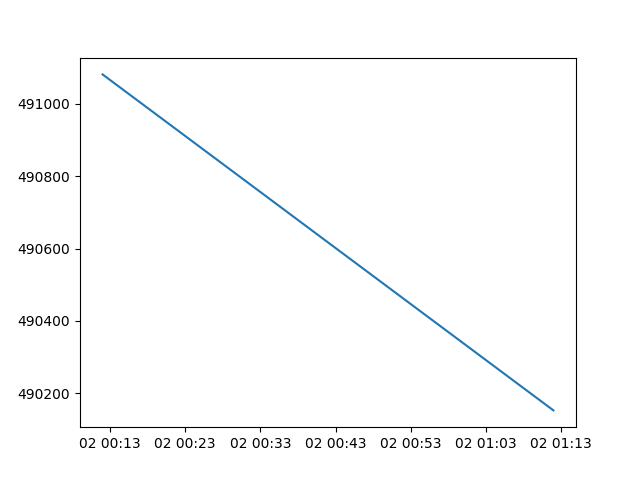

[[<matplotlib.lines.Line2D at 0x7f8b411ab390>],

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
data = hd.data()['Close']
x = data.index
y = data.values
sd = 1
upper, middle, lower = talib.BBANDS(data.values, timeperiod=20, matype=talib.MA_Type.SMA, nbdevup=sd, nbdevdn=sd)
[plt.plot(x, val) for val in [y, upper, middle, lower]]

In [ ]:
data.values

array([ 491081.,  490153.])

## References

- [Deep Q-LearningでFXしてみた](http://recruit.gmo.jp/engineer/jisedai/blog/deep-q-learning/)
- [slide](https://www.slideshare.net/JunichiroKatsuta/deep-qlearningfx)

## TODO

足の配列について、indexの外を読み出そうとしている節があるので直す。

```json
{
 insertId:  "1l630l2g1k8tnms"  
 jsonPayload: {…}  
 logName:  "projects/deep-fx/logs/deepfx"  
 receiveTimestamp:  "2017-11-18T17:12:18.459939016Z"  
 resource: {…}  
 severity:  "WARNING"  
 timestamp:  "2017-11-18T17:12:18.459939016Z"  
}
```

In [ ]:
from notebook.auth import passwd;print(passwd())

Enter password: ········
Verify password: ········
Passwords do not match.
Enter password: ········
Verify password: ········
sha1:15be4e99eaed:fe420fd06a231287e167c49812c09a5eccd5127c
